In [1]:
import sys
sys.path.append('..')  # Add the parent directory to sys.path

In [2]:
import os, re, glob, torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.optim import Adam
from datetime import datetime
from matplotlib import pyplot as plt
from src.models import CBOW, CBOWDeep
from src.utils import train, compute_accuracy, set_device, plot_performance_over_time

In [3]:
SEED = 265
torch.manual_seed(SEED)

DEVICE = set_device("cuda")
print(f"Using device: {DEVICE}")

Using device: cuda


# Tokenization and creation of datasets

In [4]:
TOKENIZER_EN = get_tokenizer("basic_english")
PATH_GENERATED = "../generated_data/"
MIN_FREQ = 100
DEBUGGING = False

In [5]:
def read_files(datapath="../data/data_train/", debug=DEBUGGING):
    files = glob.glob(datapath + "*.txt")
    if debug:
        files = files[:1]

    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

In [6]:
def tokenize(lines, tokenizer=TOKENIZER_EN):
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

In [7]:
def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    no_digits = "\w*[0-9]+\w*"
    no_names = "\w*[A-Z]+\w*"
    no_spaces = "\s+"

    for line in lines:
        line = re.sub(no_digits, " ", line)
        line = re.sub(no_names, " ", line)
        line = re.sub(no_spaces, " ", line)
        yield tokenizer(line)

In [8]:
def count_freqs(words, vocab):
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

In [9]:
def create_vocabulary(lines, min_freq=MIN_FREQ):
    vocab = build_vocab_from_iterator(
        yield_tokens(lines), min_freq=min_freq, specials=["<unk>"]
    )
    vocab.append_token("i")
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [10]:
# Tokenize texts
# Load tokenized texts if they are generated
# else, create it and save it

if os.path.isfile(PATH_GENERATED + "words_train.pt"):
    words_train = torch.load(PATH_GENERATED + "words_train.pt")
    words_val = torch.load(PATH_GENERATED + "words_val.pt")
    words_test = torch.load(PATH_GENERATED + "words_test.pt")
else:
    lines_book_train = read_files("../data/data_train/")
    lines_book_val = read_files("../data/data_val/")
    lines_book_test = read_files("../data/data_test/")

    words_train = tokenize(lines_book_train)
    words_val = tokenize(lines_book_val)
    words_test = tokenize(lines_book_test)

    torch.save(words_train, PATH_GENERATED + "words_train.pt")
    torch.save(words_val, PATH_GENERATED + "words_val.pt")
    torch.save(words_test, PATH_GENERATED + "words_test.pt")

In [11]:
# Create vocabulary

VOCAB_FNAME = "vocabulary.pt"

if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    vocab = create_vocabulary(lines_book_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED + VOCAB_FNAME)
    vocab_df = pd.DataFrame([w for w in vocab.lookup_tokens(range(len(vocab)))])
    vocab_df.to_csv(PATH_GENERATED+"vocab.tsv", sep="\t", header=False, index=False)

In [12]:
# Analysis

VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Total number of words in the validation dataset:   ", len(words_val))
print("Total number of words in the test dataset:         ", len(words_test))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words in the validation dataset:  ", len(set(words_val)))
print("Number of distinct words in the test dataset:  ", len(set(words_test)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152
Number of distinct words in the training dataset:   52105
Number of distinct words in the validation dataset:   5778
Number of distinct words in the test dataset:   9585
Number of distinct words kept (vocabulary size):    1880


In [13]:
WEIGHTS_FNAME = "class_weights.pt"

if os.path.isfile(PATH_GENERATED + WEIGHTS_FNAME):
    weights = torch.load(PATH_GENERATED + WEIGHTS_FNAME)
else:
    freqs = count_freqs(words_train, vocab)
    weights = 1 / freqs
    torch.save(weights, PATH_GENERATED + "class_weights.pt")
# print(
#     "occurences:\n",
#     [(f.item(), w) for (f, w) in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))],
# )

In [14]:
# Define targets

MAPPING_FNAME = "mapping.pt"
# true labels for this task:
if os.path.isfile(PATH_GENERATED + MAPPING_FNAME):
    MAP_TARGET = torch.load(PATH_GENERATED + MAPPING_FNAME)
else:
    MAP_TARGET = {vocab[w]: w for w in vocab.lookup_tokens(range(VOCAB_SIZE))}
    torch.save(MAP_TARGET, PATH_GENERATED + "mapping.pt")

# context size for behind and after target
CONTEXT_SIZE = 6

# define context / target pairs

In [15]:
def create_dataset(text, vocab, context_size=CONTEXT_SIZE, map_target=MAP_TARGET):
    """
    Create a pytorch dataset of context / target pairs from a text
    """

    n_text = len(text)
    n_vocab = len(vocab)

    if map_target is None:
        map_target = {i: i for i in range(n_vocab)}

    txt = [vocab[w] for w in text]

    contexts = []
    targets = []

    for i in range(context_size, n_text - context_size):

        t = txt[i]
        # exclude <unk>(0) and/or punctuation(1) from targets
        if map_target[t] in ["<unk>", ",", ".", "(", ")", "?", "!"]:
            pass
        else:
            # print("\nindex: ", i)
            # print("Context indices: ", i-context_size, i + context_size+1)
            c = txt[i - context_size : i] + txt[i + 1 : i + context_size + 1]
            # targets.append(map_target[t])
            targets.append(t)
            contexts.append(torch.tensor(c))

    # contexts of shape (N_dataset, contexts_size)
    # targets of shape (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

In [16]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it.
    """
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset

# Training embedding

In [17]:
data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

print(f"Context, target pairs in training set: {len(data_train)}")
print(f"Context, target pairs in validation set: {len(data_val)}")
print(f"Context, target pairs in test set: {len(data_test)}")

Context, target pairs in training set: 1917175
Context, target pairs in validation set: 36215
Context, target pairs in test set: 83640


In [18]:
vocab = torch.load(PATH_GENERATED+"/vocabulary.pt")
vocab_weights = torch.load(PATH_GENERATED+"/class_weights.pt")
vocab_weights = vocab_weights.to(DEVICE)

In [19]:
batch_size = 64
n_epochs = 10
loss_fn = nn.NLLLoss(weight=vocab_weights)

print(f"-- Global Parameters --")
print(f"{batch_size=}")
print(f"{n_epochs=}")

model_architectures = [CBOW, CBOWDeep]

parameter_search = [
    {"lr":0.001, "embedding_dim": 12},
    {"lr":0.001, "embedding_dim": 16},
    {"lr":0.01, "embedding_dim": 12},
    {"lr":0.01, "embedding_dim": 16},
]

-- Global Parameters --
batch_size=64
n_epochs=10


In [20]:
train_loader = DataLoader(data_train, batch_size=batch_size)
val_loader = DataLoader(data_val, batch_size=batch_size)

In [21]:
if os.path.isfile(PATH_GENERATED + "embedding_model.pt"):
    print("Skipping training, loading existing model...")
else:
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    val_perf = []
    models = []
    
    for params in parameter_search:
        for architecture in model_architectures:
            print("\n-- Training with following parameters --:")
            print(f"{architecture=}")
            for name, val in params.items():
                print(f"{name}: {val}")
            torch.manual_seed(SEED)
            model = architecture(len(vocab), CONTEXT_SIZE, params["embedding_dim"])
            model.to(DEVICE)
            optimizer = Adam(model.parameters(), lr=params["lr"])
            
            train_loss, val_loss, train_acc, val_acc = train(n_epochs, model, optimizer, loss_fn, train_loader, val_loader, DEVICE)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            val_perf.append(val_acc[-1])
            models.append(model)
            print(f"Train accuracy: {train_acc[-1]*100:.3f}%")
            print(f"Validation accuracy: {val_acc[-1]*100:.3f}%")


-- Training with following parameters --:
architecture=<class 'src.models.CBOW'>
lr: 0.001
embedding_dim: 12
20:14:23.248256, Epoch: 1, train_loss: 7.319, train_accuracy: 1.100%, val_loss: 7.114, val_accuracy: 0.939%
20:18:55.541049, Epoch: 10, train_loss: 6.880, train_accuracy: 1.386%, val_loss: 7.166, val_accuracy: 1.058%
Train accuracy: 1.386%
Validation accuracy: 1.058%

-- Training with following parameters --:
architecture=<class 'src.models.CBOWDeep'>
lr: 0.001
embedding_dim: 12
20:19:33.512034, Epoch: 1, train_loss: 7.070, train_accuracy: 0.446%, val_loss: 7.922, val_accuracy: 0.323%
20:25:16.231745, Epoch: 10, train_loss: 5.887, train_accuracy: 2.041%, val_loss: 7.227, val_accuracy: 1.737%
Train accuracy: 2.041%
Validation accuracy: 1.737%

-- Training with following parameters --:
architecture=<class 'src.models.CBOW'>
lr: 0.001
embedding_dim: 16
20:25:45.994118, Epoch: 1, train_loss: 7.397, train_accuracy: 0.969%, val_loss: 7.157, val_accuracy: 0.820%
20:30:31.086546, Epoch

# Embedding selection

In [22]:
if os.path.isfile(PATH_GENERATED + "embedding_model.pt"):
    chosen_model = torch.load(PATH_GENERATED + "embedding_model.pt")
    chosen_index, train_losses, val_losses, train_accs, val_accs = torch.load(PATH_GENERATED + "embedding_plots.pt")
else:
    chosen_index = val_perf.index(max(val_perf))
    chosen_model = models[chosen_index]
    torch.save(chosen_model, PATH_GENERATED + "embedding_model.pt")
    torch.save(chosen_model.embedding, PATH_GENERATED+"embedding_matrix.pt")
    torch.save((chosen_index, train_losses, val_losses, train_accs, val_accs), PATH_GENERATED + "embedding_plots.pt")
    
    embedding_frame = pd.DataFrame(chosen_model.embedding.weight.to("cpu").detach()).astype("float64")
    embedding_frame.to_csv(PATH_GENERATED+"embedding.tsv", sep="\t", header=False, index=False)

In [23]:
print(chosen_model)

CBOWDeep(
  (embedding): Embedding(1880, 12)
  (fc1): Linear(in_features=144, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1880, bias=True)
)


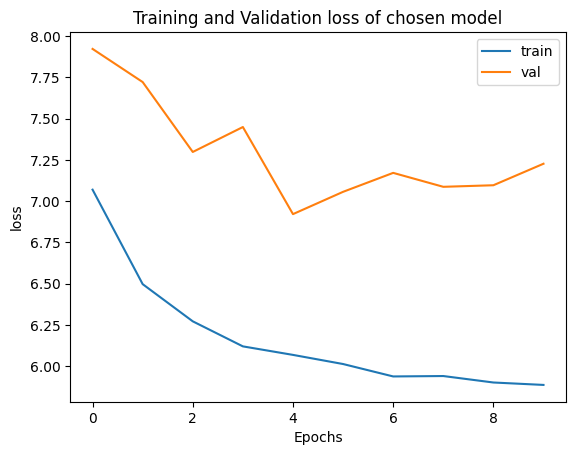

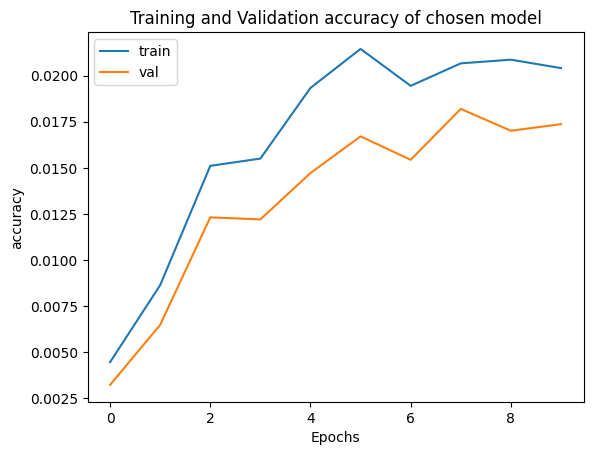

In [24]:
plot_performance_over_time(train_losses[chosen_index], val_losses[chosen_index],
                           "Training and Validation loss of chosen model", "loss",
                            f_name="../images/embedding_loss.png", save=True)
plot_performance_over_time(train_accs[chosen_index], val_accs[chosen_index],
                           "Training and Validation accuracy of chosen model", "accuracy",
                            f_name="../images/embedding_accuracy.png", save=True)

In [25]:
test_loader = DataLoader(data_test, batch_size=batch_size)

In [26]:
mapping = MAP_TARGET

In [27]:
cos = nn.CosineSimilarity(dim=1)
embedding = chosen_model.embedding.weight.clone()

print("-- 10 most similar words --")
words = ["me", "white", "man", "have", "be", "child", "yes", "what"]
for word in words:
    vocab_index = vocab[word]
    similarity = cos(embedding[vocab_index].view(1, -1), embedding)
    idx_ten = torch.topk(similarity, 11).indices
    most_similar = [mapping[int(i)] for i in idx_ten][1:] #  Exclude similarity with itself
    if vocab_index == 0:
        print(f"{word}({mapping[int(vocab_index)]}): {most_similar}")
    else:
        print(f"{word}: {most_similar}")

-- 10 most similar words --
me: ['him', 'us', 'thee', 'you', 'ourselves', 'them', 'someone', 'something', 'king', 'itself']
white: ['bare', 'blue', 'broken', 'branches', 'soft', 'top', 's', 'wild', 'red', 'shade']
man: ['air', 'woman', 'success', 'sister', 'lady', 'kinds', 'note', 'lad', 'weather', 'soul']
have: ['had', 'be', 'already', 've', 'has', 'always', 'who', 'been', 'being', 'were']
be: ['have', 'being', 'been', 'already', 've', 'had', 'become', 'am', 'was', 'feel']
child: ['moment', 'voice', 'words', 'thing', 'instant', 'people', 'country', 'events', 'manner', 'size']
yes: ['pleased', 'wrong', 'nothing', 'ourselves', 'why', 'us', 'because', 'perhaps', 'whether', 'complete']
what: ['to-morrow', 'that', 'whether', 'nothing', 'prince', 'first', 'if', 'this', 'those', 'wrong']


In [28]:
example_idx = 1
context, target = data_val[example_idx][0], data_val[example_idx][1]
context = context.view(1, -1)
chosen_model.eval()
out = chosen_model(context.to(DEVICE))
out = out.to("cpu")

print("Context indices: ", context)
print("Context words: ", end=" ")
for idx in context[0]:
    print(mapping[int(idx)], end=" ")
print()

most_likely_idx = out.argmax()
print("Target index: ", target)
print("Predicted index: ", most_likely_idx)
most_likely_word = mapping[int(most_likely_idx)]
print("Target word: ", mapping[int(target)])
print("Predicted word: ", most_likely_word)

Context indices:  tensor([[   0,    3,  222, 1879,    3,  100,    7,    0,   32,    2,    0,    5]])
Context words:  <unk> . part i . ( a <unk> from the <unk> of 
Target index:  tensor(155)
Predicted index:  tensor(569)
Target word:  being
Predicted word:  although
